In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pymc3_ext as pmx
import pymc3 as pm
from tqdm.notebook import tqdm
from scipy.special import factorial
import starry
import exoplanet as xo
import pymc3_ext as pmx  
from corner import corner
from astropy.table import Table
import lightkurve as lk
import arviz as az
from sklearn.metrics import mean_squared_error
import theano.tensor as tt
import pandas as pd
from sklearn.metrics import mean_squared_error
starry.config._lazy = True
starry.config.quiet = True


In [2]:
#CARGAR DATOS OBSERVACIONALES DE LOS SECTORES DISPONIBLES
#Sector 5
data5=pd.read_csv('Data/cvso315_s_5_corrected.csv')
Ta = data5['time'].values-np.min(data5["time"].values)
fa = data5['flux'].values
sda = data5['flux_err'].values
#Sector 32

data32=pd.read_csv('Data/cvso315_s_32_corrected.csv')
Tb = data32['time'].values-np.min(data32["time"].values)
fb = data32['flux'].values/1.04
sdb = data32['flux_err'].values

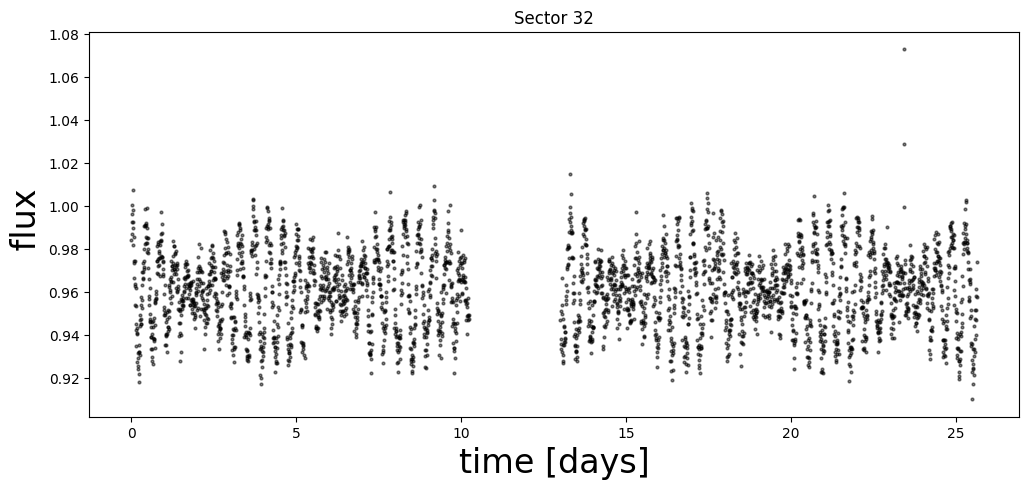

In [3]:
#Visualizacion de Curva
fig, ax = plt.subplots(1, figsize=(12, 5))
ax.plot(Tb, fb, "k.", alpha=0.5, ms=4)
ax.set_xlabel("time [days]", fontsize=24)
plt.title('Sector 32')
ax.set_ylabel(" flux", fontsize=24);

In [4]:
#Definicion de parametros
true_lats = [0, 71.8]#Latitudes de las manchas
true_lons = [0,30.841]#longitudes de las manchas
spot_guess = [0.42,0.42] # spot size
intensity_guess = [-0.9,-0.8] #Intensidad Mancha
inc_guess = -6.927  # inclination
u1  = 0.5  # linear limb darkening coeff
#amp = 1 #amplitud/
alpha_guess = 0.11 #0.10869  # differential rotation shear
P = 0.414  # Periodo ecuatorial
omega_eq = 360.0 / P#velocidad en el ecuador de la estrella
flux_err = sdb
time = np.linspace(0, 30, 1000)#tiempo simulado 
time_ani = time[::10]#tiempo de animacion
res = 300#resolucion de la animacion
Label = "cvso315_32a"
escala=0.78
print(sdb)
print(fb)

[0.00341636 0.00341419 0.00342405 ... 0.00346804 0.00347645 0.00349282]
[0.98403607 0.98706779 0.99250753 ... 0.96155415 0.95773969 0.97407837]


In [5]:
def solve(lat_guess, lon_v2gues, spot_guess, intensity_guess, inc_guess, u1, alpha_guess, escala):
    nspots = len(lat_guess)

    with pm.Model() as model:

        # Definir variables y funciones 
        maps = [None for _ in range(nspots)]
        flux_model = [None for _ in range(nspots)]
        omega = [None for _ in range(nspots)]
        PositiveNormal = pm.Bound(pm.Normal, lower=0.0)
        NegativeNormal = pm.Bound(pm.Normal, upper=0.0)
        #Variables bajo distribucion Normal 
        scale = pm.Normal("scale", mu = escala, sd = 0.01)
        alpha = pm.Normal("alph", mu=alpha_guess, sd=0.012, testval=alpha_guess)
        inc = pm.Normal("inc", mu=inc_guess, sd=2, testval=inc_guess)
        lon = pm.Normal("lon", mu = lon_v2gues, sd = 10, testval = lon_v2gues )

        # Añadir cada mancha
        for n in range(nspots):
            lat = pm.Normal(f"lat{n}", mu=lat_guess[n], sd=2, testval=lat_guess[n])
            spize = PositiveNormal(f"spot_size{n}", mu=spot_guess[n], sd=0.05, testval=spot_guess[n])
            inten = NegativeNormal(f"intensity{n}", mu=intensity_guess[n], sd=0.1, testval=intensity_guess[n])
            
        
            
            # Usar `lon_v1g` para la primera mancha y `lon_v2gues` para la segunda
            lon_value = lon_v2gues if n == 1 else lon_v1g
            
            # Crear el mapa y añadir la mancha
            maps[n] = starry.Map(10, 1)
            #maps[n].amp = amp
            maps[n].inc = inc
            maps[n][1] = u1
            maps[n].add_spot(intensity=inten, sigma=spize, lat=lat, lon=lon_value)
            
            # Calcular la velocidad angular de la mancha
            omega[n] = omega_eq * (1 - alpha * np.sin(lat * np.pi / 180.0) ** 2)
            flux_model[n] = maps[n].flux(theta=omega[n] * Tb)
        
        # Modelo de flujo total
        total_flux_model = scale * pm.math.sum(flux_model, axis=0)
        pm.Deterministic("flux_model", total_flux_model)

        # Guardar la predicción inicial
        flux_model_guess = pmx.eval_in_model(total_flux_model)

        # Función de verosimilitud
        pm.Normal("obs", mu=total_flux_model, sd=flux_err, observed=fb)

        # Optimización inicial
        map_soln = pmx.optimize()
   
    with model:
        trace = pmx.sample(tune=1000, draws=1000, start=map_soln, chains=4, target_accept=0.92)
    
    
    # Devuelve el flujo con inferencia, el flujo guess y la traza con la informacion de los posteriors de la inferencia
    return map_soln["flux_model"], flux_model_guess, trace



# Parámetros iniciales mas agregar un ligero ruido en latitud y longitud
np.random.seed(0)
lat_guess = true_lats + 0.5 * np.random.randn(2)
lon_v2guess = true_lons[1] + 0.5 * np.random.randn(1)
lon_v2gues = lon_v2guess.item()
lon_v1g = true_lons[0]

#Iniciar inferencia
flux_model,flux_model_guess, trace = solve(
    lat_guess, lon_v2gues, spot_guess, intensity_guess, inc_guess, u1, alpha_guess, escala)

optimizing logp for variables: [intensity1, spot_size1, lat1, intensity0, spot_size0, lat0, lon, inc, alph, scale]


message: Desired error not necessarily achieved due to precision loss.
logp: -36232.45687709834 -> 4506.406497329145
/home/vox/anaconda3/envs/py39/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intensity1, spot_size1, lat1, intensity0, spot_size0, lat0, lon, inc, alph, scale]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37883 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


 MSE de optimizacion: 0.0003679032984552595


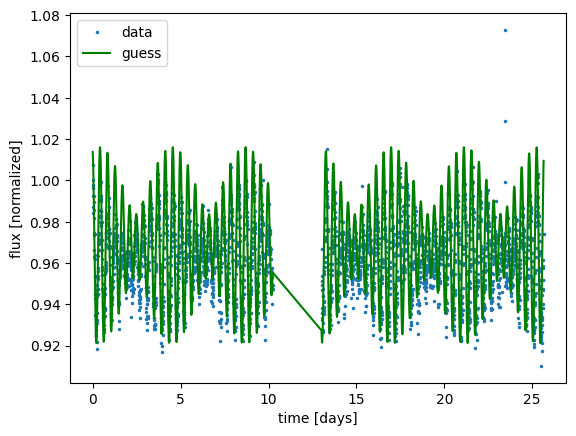

In [7]:
MSE1 = mean_squared_error(fb, flux_model_guess)
print(" MSE de optimizacion:",MSE1)
plt.plot(Tb, fb, ".", ms=3, label="data")
plt.plot(Tb, flux_model_guess,"g", label="guess")
plt.ylabel("flux [normalized]")
plt.xlabel("time [days]")
plt.legend();

 MSE de optimizacion: 0.0003679032984552595
 MSE de inferencia: 7.896119347413792e-05
3286


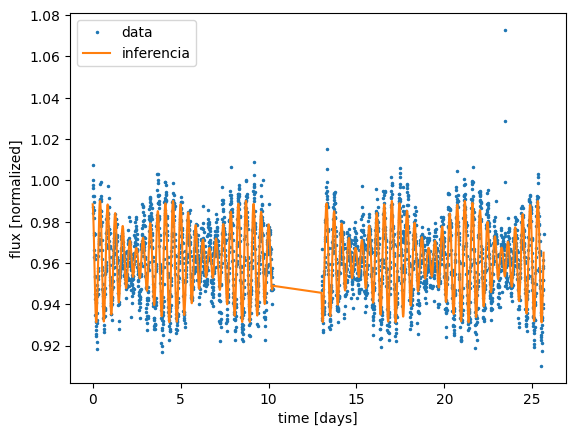

In [8]:
MSE2 = mean_squared_error(fb, flux_model)
print(" MSE de optimizacion:",MSE1)
print(" MSE de inferencia:",MSE2)
plt.plot(Tb, fb, ".", ms=3, label="data")
plt.plot(Tb, flux_model, label="inferencia")
print(len(flux_model))
plt.ylabel("flux [normalized]")
plt.xlabel("time [days]")
plt.legend();


In [9]:
import numpy as np
import pandas as pd

nspots = len(lat_guess)

# Lista de variables
lat_vars = [f"lat{n}" for n in range(nspots)]
lon_vars = [f"lon{n}" for n in range(nspots)]
spot_vars = [f"spot_size{n}" for n in range(nspots)]
int_vars = [f"intensity{n}" for n in range(nspots)]
var_names = ["scale"] + ["inc"] + ["lon"] + ["alph"] + lat_vars  + spot_vars + int_vars 

# Obtener los valores de las variables
escala = trace.get_values("scale").reshape(-1)
incli = trace.get_values("inc").reshape(-1)
longi = trace.get_values("lon").reshape(-1)
alfa = trace.get_values("alph").reshape(-1)



# Obtener valores de variables para ambas manchas
latitudes = np.column_stack([trace.get_values(var) for var in lat_vars])
manchas = np.column_stack([trace.get_values(var) for var in spot_vars])
intensidad = np.column_stack([trace.get_values(var) for var in int_vars])

# Diccionario para agregar a un archivo que guarde los posteriors
inf_pos = {"scale": escala, "inc": incli, "lon":longi, "alph":alfa}

# Agregar Valores
for i in range(nspots):
    inf_pos[f"lat{i}"] = latitudes[:, i]
    inf_pos[f"spot_size{i}"] = manchas[:,i]
    inf_pos[f"intensity{i}"]= intensidad[:,i]

# Crear Data Frame
df_pos = pd.DataFrame(inf_pos)
df_pos.to_csv(Label+"_Posteriorsa.csv", sep=',')
column_means = df_pos.mean()
print(column_means)

# Percentiles de flujo
curve = trace.get_values("flux_model")

# Calcular la media de las muestras crudas a través del eje 0 
flux_mean = curve.mean(axis=0)

# Crear un DataFrame con los tiempos y la media del flujo
flux_data = {
    "Time (Ta)": Tb,
    "Flux": flux_mean
}
df_flux = pd.DataFrame(flux_data)

# Guardar el DataFrame en un archivo CSV
df_flux.to_csv(Label + "_Raw_Flux_Meana.csv", index=False)


# Obtener los Percentiles de FLujo
curve = trace.get_values("flux_model")

print("Shape of curve:", curve.shape)

q16, q50, q84 = np.percentile(curve, [16, 50, 84], axis=0)


print("Shape of q50:", q50.shape)
print("Shape of Tb:", Ta.shape)

if q50.shape != Tb.shape:
    raise ValueError("The shape of the percentiles does not match the shape of Tb.")

# Curvas de luz
Curva_Q50 = lk.LightCurve(time=Tb, flux=q50)
Curva_Q16 = lk.LightCurve(time=Tb, flux=q16)
Curva_Q84 = lk.LightCurve(time=Tb, flux=q84)

# Guardarlas en CSV
strm_1 = Curva_Q50.to_csv()
with open(Label + "_q50.csv", "w") as text_file:
    text_file.write(strm_1)

strm_2 = Curva_Q16.to_csv()
with open(Label + "_q16.csv", "w") as text_file:
    text_file.write(strm_2)

strm_3 = Curva_Q84.to_csv()
with open(Label + "_q84.csv", "w") as text_file:
    text_file.write(strm_2)


scale          0.776207
inc           -6.816734
lon           31.174572
alph           0.108972
lat0           8.848292
spot_size0     0.189927
intensity0    -0.819045
lat1          75.184791
spot_size1     0.590458
intensity1    -0.835383
dtype: float64
Shape of curve: (4000, 3286)
Shape of q50: (3286,)
Shape of Tb: (1109,)


In [12]:
data32=pd.read_csv('Data/cvso315_s_32_corrected.csv')
raw32=   pd.read_csv('cvso315_32_Raw_Flux_Mean.csv')
Tb = data32['time'].values-np.min(data32["time"].values)
fb = data32['flux'].values
sdb = data32['flux_err'].values

#Posterior
Pos32= pd.read_csv('cvso315_32_Posteriors.csv')
Pos5 = pd.read_csv('Data/Diferencial/cvso315_5_Posteriors.csv')
#Cuartiles
q1632= pd.read_csv('Data/Diferencial/cvso315_32_q16.csv')
q5032= pd.read_csv('Data/Diferencial/cvso315_32_q50.csv')
q8432= pd.read_csv('Data/Diferencial/cvso315_32_q84.csv')
q165=  pd.read_csv('Data/Diferencial/cvso315_5_q16.csv')
q505=  pd.read_csv('Data/Diferencial/cvso315_5_q50.csv')
q845=  pd.read_csv('Data/Diferencial/cvso315_5_q84.csv')
#Flujo inf
finf = raw32['Flux'].values


#(np.median(Pos32["spotsize0"]),np.median(Pos32["spotsize1"]))

# Cálculo de chi cuadrado
chi_squared = np.sum(((fb - finf) ** 2) / sdb**2)

# Grados de libertad (número de datos - 1)
grados_de_libertad = len(fb) - 1

# Cálculo de chi cuadrado reducido
chi_squared_reducido = chi_squared / grados_de_libertad
# Mse
MSE = mean_squared_error(fb, finf)

# Resultados
print("Chi cuadrado:", chi_squared)
print("Chi cuadrado reducido:", chi_squared_reducido)
print("Su MSE:",MSE)

peri=(0.459-0.414)/0.414
print(f"alfa es",peri)

Chi cuadrado: 24092.395440789907
Chi cuadrado reducido: 7.334062539053244
Su MSE: 8.555273291285672e-05
alfa es 0.10869565217391315


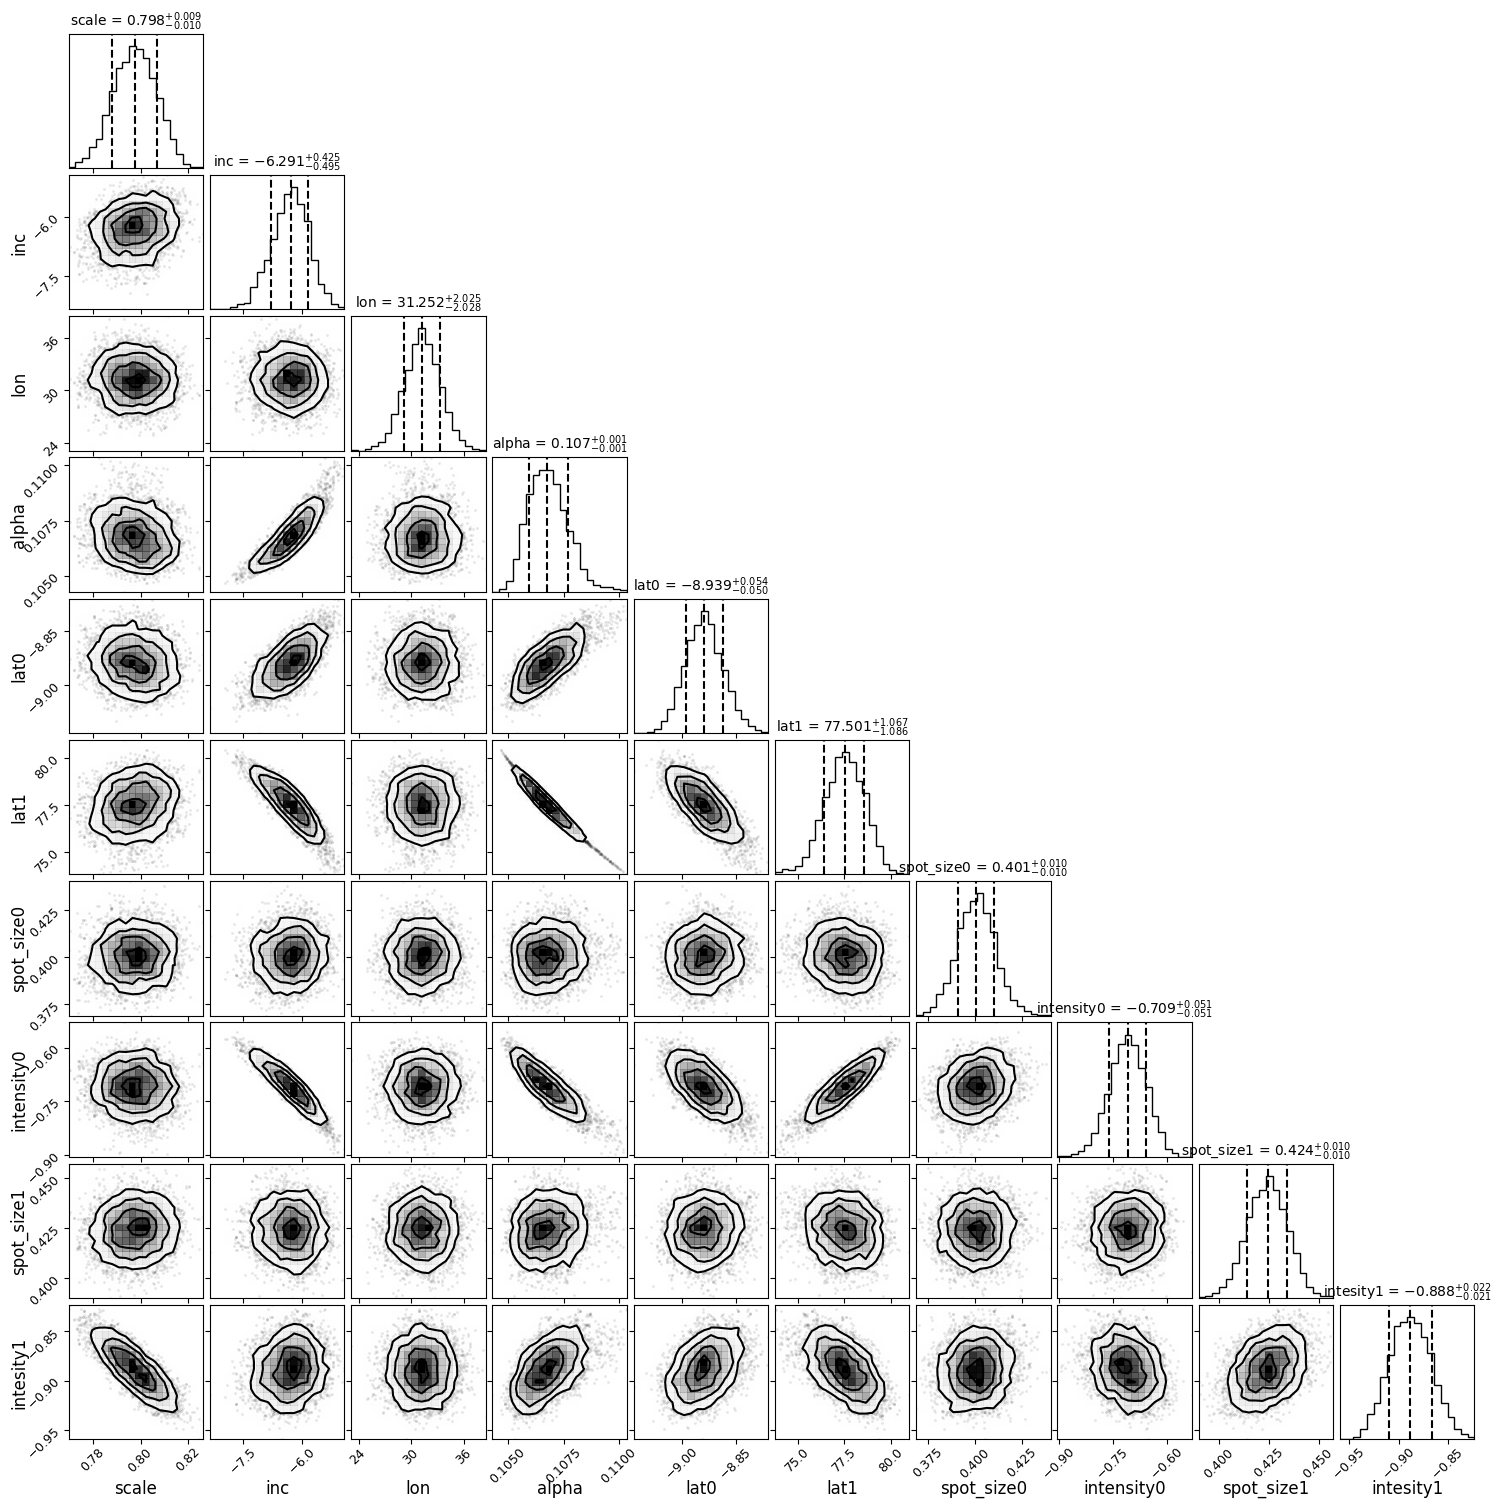

In [13]:
array_a = Pos32[['scale','inc', "lon","alph", 'lat0', 'lat1', 'spot_size0', "intensity0","spot_size1","intensity1"]].values

# Configuración de corner
CORNER_KWARGS = dict(
    smooth=0.5,
    label_kwargs=dict(fontsize=12),
    title_kwargs=dict(fontsize=10),
    quantiles=[0.16, 0.5, 0.84],
    plot_density=True,
    plot_datapoints=True,
    fill_contours=False,
    show_titles=True,
    max_n_ticks=3,
    title_fmt=".3f"
)

# Crear la figura con corner
figure = corner(array_a, labels=['scale', 'inc', 'lon',"alpha",'lat0', 'lat1', "spot_size0","intensity0","spot_size1","intesity1"], fig=plt.figure(figsize=(15, 15)),
                use_math_text=True, **CORNER_KWARGS)

# Ajustes en los ejes
for ax in figure.get_axes():
    ax.tick_params(axis='both', labelsize=9)
    ax.tick_params(axis='x', which='both', pad=1)
    ax.tick_params(axis='y', which='both', pad=1)


# Guardar la figura
figure.savefig('infernecia_top.png', dpi=300)